testing ground for prophet stuff (for now)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add all imports here
%pip install -r requirements.txt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from prophet import Prophet
from datetime import datetime


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Importing plotly failed. Interactive plots will not work.


In [3]:
load_azure_data()

In [4]:
df = pd.read_csv("data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt")
df["start_timestamp"] = df["end_timestamp"] - df["duration"]
df = df.sort_values(by="start_timestamp", ascending=True)

In [5]:
single_function_df = df.loc[df["func"] == df["func"].mode()[0]].copy()
single_function_df["end_timestamp"] = single_function_df['end_timestamp'] - single_function_df['start_timestamp'].iloc[0]
single_function_df["start_timestamp"] = single_function_df['start_timestamp'] - single_function_df['start_timestamp'].iloc[0]
single_function_df.head()

,app,func,end_timestamp,duration,start_timestamp
956,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,0.611000,0.611,0.000000
957,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.418832,0.171,1.247832
958,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.599366,0.007,1.592366
959,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,2.946063,0.006,2.940063
960,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,3.222266,0.001,3.221266


In [6]:
reference_time = pd.to_datetime(datetime.now())

BIN_SIZE = 3

bins = range(0, int(single_function_df["start_timestamp"].max()) + BIN_SIZE, BIN_SIZE)
single_function_df["time_bucket"] = pd.cut(single_function_df["start_timestamp"], bins=bins, right=False)
bucket_counts = single_function_df['time_bucket'].value_counts().sort_index()

In [7]:
train_df = bucket_counts.reset_index()
train_df["time_bucket"] = reference_time + pd.to_timedelta(train_df.index * BIN_SIZE, unit="s")
train_df = train_df.rename(columns={"time_bucket": "ds", "count": "y"}).head(5000)
train_df.head()

,ds,y
0,2025-03-20 17:23:49.788386,4
1,2025-03-20 17:23:52.788386,5
2,2025-03-20 17:23:55.788386,8
3,2025-03-20 17:23:58.788386,4
4,2025-03-20 17:24:01.788386,4


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5000 non-null   datetime64[ns]
 1   y       5000 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 78.3 KB


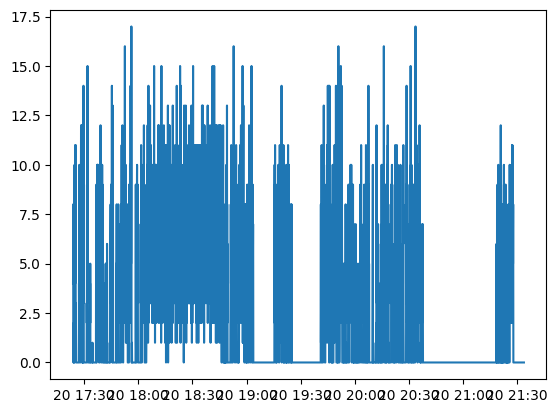

In [9]:
plt.plot(train_df["ds"], train_df["y"])

In [10]:
model = Prophet(changepoint_prior_scale=1)
model.add_seasonality(name='seconds_level', period=60, fourier_order=20)
model.add_seasonality(name="minute_level", period=3600, fourier_order=5)
model.fit(train_df)

17:23:52 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing


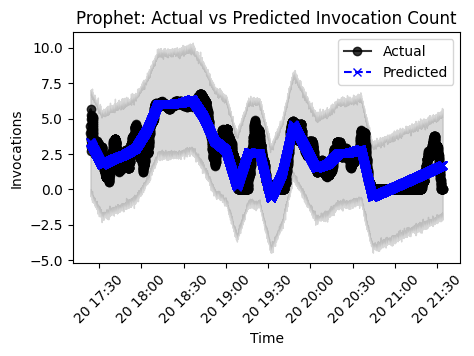

In [11]:
forecast_train = model.predict(train_df[['ds']])
df_results = train_df[['ds', 'y']].merge(forecast_train[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

df_results["y_smoothed"] = df_results["y"].rolling(window=100, min_periods=1).mean()


plt.figure(figsize=(5, 3))
plt.plot(df_results["ds"], df_results["y_smoothed"], label="Actual", marker="o", linestyle="-", color="black", alpha=0.8)
plt.plot(df_results["ds"], df_results["yhat"], label="Predicted", marker="x", linestyle="--", color="blue")

plt.fill_between(df_results["ds"], df_results["yhat_lower"], df_results["yhat_upper"], color="gray", alpha=0.3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Invocations")
plt.title("Prophet: Actual vs Predicted Invocation Count")
plt.xticks(rotation=45)
plt.show()


In [12]:
mae = np.mean(np.abs(forecast_train['yhat'] - train_df['y']))
rmse = np.sqrt(np.mean((forecast_train['yhat'] - train_df['y'])**2))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 2.1215270832290596
RMSE: 2.8271415779014095


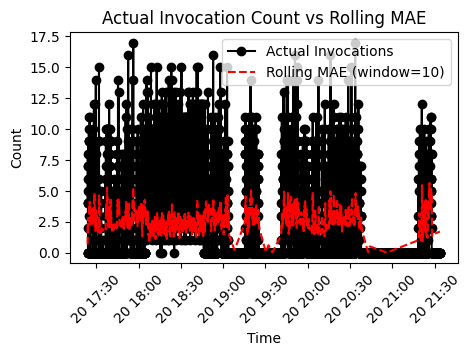

In [13]:
df_results["abs_error"] = np.abs(df_results["y"] - df_results["yhat"])
df_results["rolling_mae"] = df_results["abs_error"].rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(5, 3))
plt.plot(df_results["ds"], df_results["y"], label="Actual Invocations", marker="o", linestyle="-", color="black")
plt.plot(df_results["ds"], df_results["rolling_mae"], label="Rolling MAE (window=10)", linestyle="--", color="red")

plt.xlabel("Time")
plt.ylabel("Count")
plt.title("Actual Invocation Count vs Rolling MAE")
plt.legend()
plt.xticks(rotation=45)
plt.show()

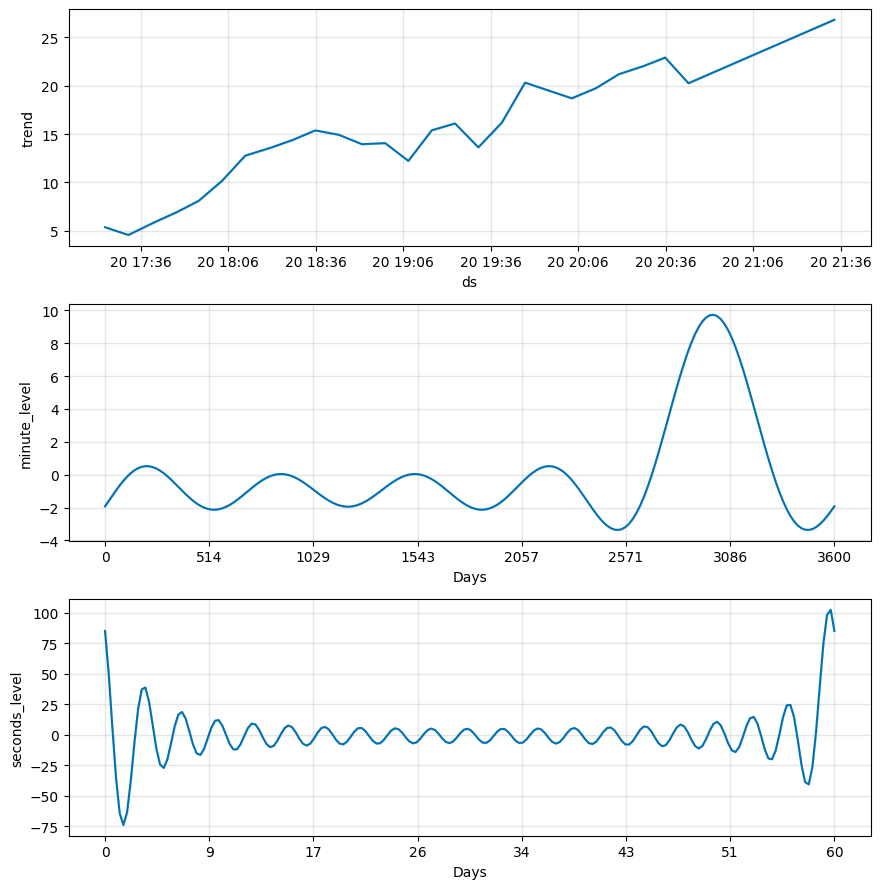

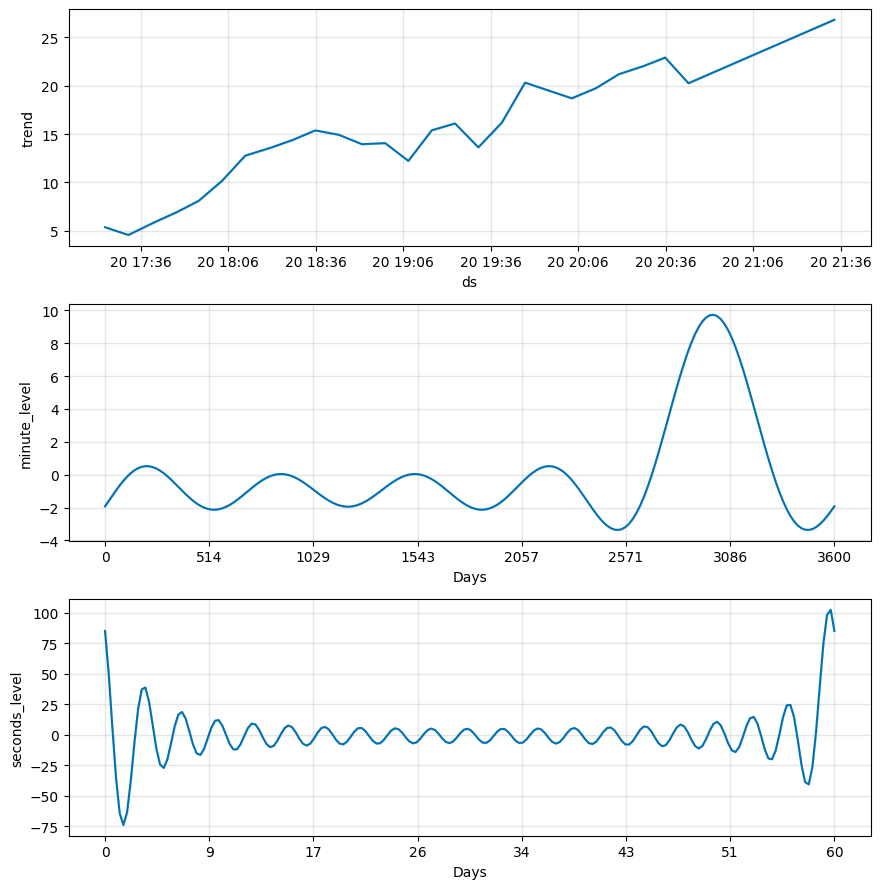

In [14]:
model.plot_components(forecast_train)